# <span style="color:red"> Facial Keypoints Detection </span>
### A computer vision project to build a facial keypoints detection system.
### <span style="color:green"> Notebook 4 of 4: Applications - Facial filters, Face Blur </span>

<img src="auxil/images/_project_intro.png" style="margin:auto" width="600"/>

## <span style="color:SteelBlue"> Project Overview </span>

- Facial keypoints detection system has variety of applications, including: 
  - Facial tracking.
  - Facial pose recognition.
  - Facial filters.
  - Emotion recognition.
  - Medical diagnosis: Identifying dysmorphic facial symptoms.
- Detecting facial keypoints is a challenging problem given the variations in both facial features as well as image conditions. Facial features may differ according to size, position, pose and expression, while image qualtiy may vary with illumination and viewing angle.  
- In this project, **Convolutional Neural Network (CNN)** based facial keypoints detector system has been implemented to detect 68 facial keypoints (also called facial landmarks) around important areas of the face: the eyes, corners of the mouth, the nose, etc. using **computer vision techniques** and **deep learning architectures**.  
- The project is broken up into a few main parts in 4 Python notebooks:  
  - [Notebook 1](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/1.%20Load%20and%20Visualize%20Data.ipynb): Loading and Visualizing the Facial Keypoint Data.  
  - [Notebook 2](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/2.%20Define%20the%20Network%20Architecture.ipynb): Defining and Training a Convolutional Neural Network (CNN) to Predict Facial Keypoints.  
  - [Notebook 3](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/3.%20Facial%20Keypoint%20Detection%2C%20Complete%20Pipeline.ipynb): Facial Keypoint Detection Using Haar Cascades and a Trained CNN.  
  - [Notebook 4](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/4.%20Applications%20-%20Facial%20filters%2C%20Face%20Blur.ipynb): Applications - Facial filters, Face Blur.  
    _(Note: This notebook is Notebook 4.)_
- The implemented Python package code is [facial_keypoints_detecter](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter).  

#### Author: Shashank Kumbhare
email: shashankkumbhare8@gmail.com  
phone: (682) 812-9211  
[LinkedIn](https://www.linkedin.com/in/shashank-kumbhare/)  

[View this project on GitHub](https://github.com/ShashankKumbhare/facial-keypoints-detecter)  
[View package on PyPI]()  
[Link to the implemented package code](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter)

# <span style="color:crimson"> 1. Facial filters </span>

Using our trained facial keypoint detector model, we can now do things like add filters to a person's face, automatically.

`facial_keypoints_detecter` package provides some facial filters as application of facial keypoints detecter system.

<table>
<tr>
<td> <img src="auxil/images/face_filter_ex2.png" style="height: 230px;"/> </td>
<td> <img src="auxil/images/group_face.png"      style="height: 230px;"/> </td>
<td> <img src="auxil/images/group_face_blur.png" style="height: 230px;"/> </td>
</tr>
<tr>
<td colspan="1"><center> Facial filter: Sunglasses </center></td>
<td colspan="2"><center> Face Blur </center></td>
</tr>
</table>


### <span style="color:SteelBlue"> Import resources </span>

- This project utilizes a custom made Python package `facial_keypoints_detecter` created especially for this project.
- `facial_keypoints_detecter` contains a cnn model, pre-processing tools, plotting tools, and datasets loading tools for this project.
- Main libraries used: `PyTorch`, `OpenCV-Python`, `matplotlib`, `pandas`, `numpy`.

In [1]:
import facial_keypoints_detecter as fkd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import cv2
import os


Importing package 'facial_keypoints_detecter'...
  + Adding module 'auxil'...
  - Done!
  + Adding module 'plots'...
  - Done!
  + Adding module 'data'...
  - Done!
  + Adding module 'model'...
  - Done!
  + Adding module 'preprocessing'...
  - Done!
Package 'facial_keypoints_detecter' imported sucessfully !!
version 1.0.0



## <span style="color:SteelBlue"> Sunglass filter </span>

Let's start this process by looking at a sunglasses `sunglasses.png` that we'll be working with!

Image shape:  (1123, 3064, 4)


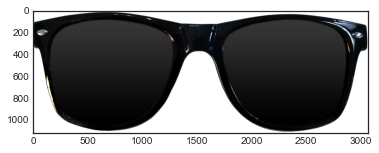

In [2]:
# Loading in sunglasses image with cv2 and IMREAD_UNCHANGED >>
sunglasses = cv2.imread("auxil/images/sunglasses1.png", cv2.IMREAD_UNCHANGED)
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

### <span style="color:SteelBlue"> The 4th dimension </span>

- Note that this image actually has *4 color channels*, not just 3 as avg RGB image does.
- This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
- It has the usual R, B, & G channels, and the 4th channel represents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. 
- The lower the value, the more transparent, or see-through, the pixel will become.
- The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 
- This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is technically covered by the transparent background of the sunglasses image!

The alpha channel looks like this (black pixels = transparent): 


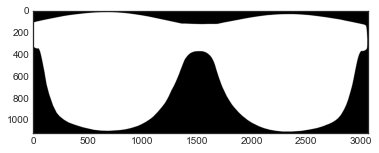

In [3]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

### <span style="color:SteelBlue"> Overlaying images </span>

- This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:
- If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

### <span style="color:SteelBlue"> Keypoint locations </span>

- In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc.
- It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.
- Next, we'll load in an example image. we can use our own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

<img src="auxil/images/landmarks_numbered.png" width=400px/>

In [4]:
# Loading in training data >>
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [5]:
net = fkd.model.Net()
# net.load_model('saved_models/20221103_02_augmented_dataset_2fc_10epochs_working.pt')
# net.load_model('saved_models/20221103_03_augmented_dataset_2fc_20epochs.pt')
# net.load_model('saved_models/20221103_04_augmented_dataset_2fc_30epochs_batch100.pt')
# net.load_model('saved_models/20221103_04_augmented_dataset_1fc_relu_30epochs_batch2000_lr0.0001.pt')
# net.load_model('saved_models/20221103_04_augmented_dataset_1fc_elu_30epochs_batch100_lr0.0001.pt')
# net.load_model('saved_models/20221103_03_augmented_dataset_1fc_elu_30epochs_batch2000_lr0.0001.pt')
# net.load_model('saved_models/20221103_06_augmented_dataset_1fc_relu_20epochs_batch32_lr0.0001.pt')
# net.load_model('saved_models/20221103_04_augmented_dataset_2fc_30epochs_batch100.pt.')
# net.load_model('saved_models/20221102_01_3con_1fc_30epoch_batchSize10_cv2_lr0.0001_working.pt')
net.load_model('saved_models/20221102_01_elu_3con_1fc_30epoch_batchSize10_cv2_lr0.0001_working.pt')
net.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=86528, out_features=136, bias=True)
)

In [6]:
net.apps.detect_facial_keypoints

<bound method Net._detect_facial_keypoints of Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=86528, out_features=136, bias=True)
)>

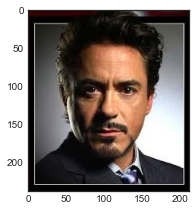

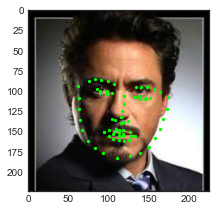

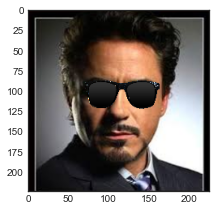

In [7]:
image = "auxil/images/robert2.png"
faces = net.apps.detect_faces(image, plot_enabled = True)
image2 = cv2.imread(image)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(image2)
keypoints, images = net.apps.detect_facial_keypoints(image, plot_enabled = True)
keypoints, images = net.apps.apply_glasses(image, file_sunglasses = "auxil/images/sunglasses1.png")

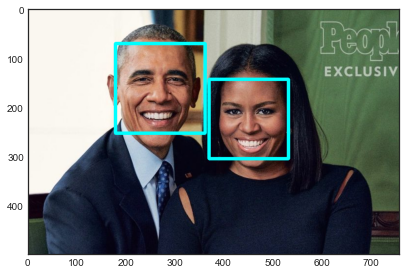

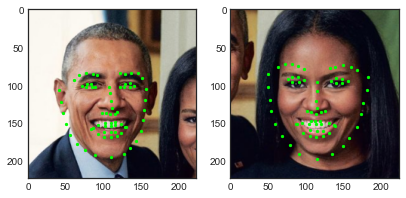

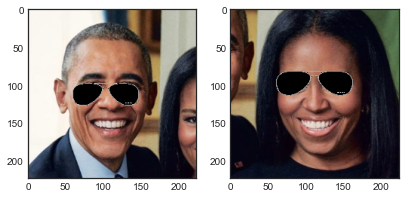

In [8]:
image = "auxil/images/obamas.png"
faces = net.apps.detect_faces(image, plot_enabled = True, figsizeScale = 2)
keypoints, images = net.apps.detect_facial_keypoints(image, plot_enabled = True)
keypoints, images = net.apps.apply_glasses(image, file_sunglasses = "auxil/images/sunglasses3.png")

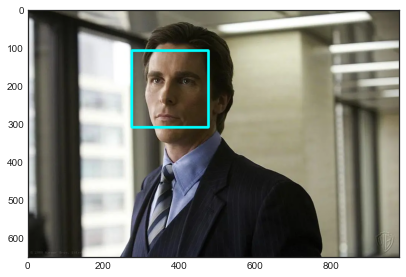

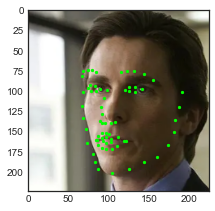

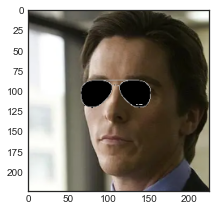

In [9]:
image = "auxil/images/bale.png"
faces = net.apps.detect_faces(image, plot_enabled = True, figsizeScale = 2)
keypoints, images = net.apps.detect_facial_keypoints(image, plot_enabled = True)
keypoints, images = net.apps.apply_glasses(image, file_sunglasses = "auxil/images/sunglasses3.png")

In [10]:
len(images)

1

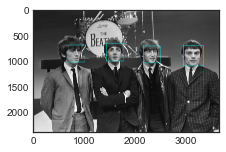

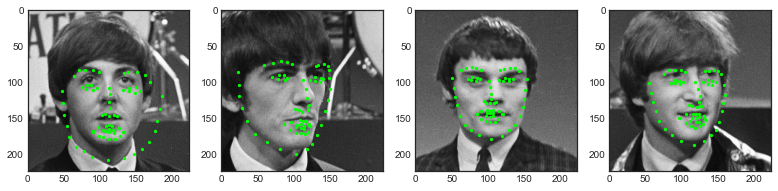

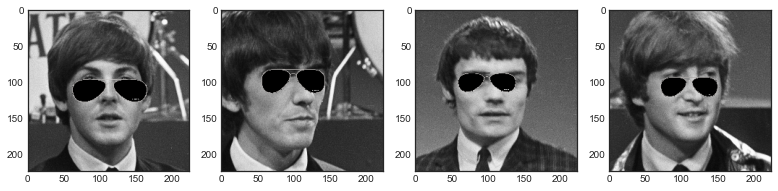

In [11]:
image = "auxil/images/the_beatles.png"
faces = net.apps.detect_faces(image, plot_enabled = True)
keypoints, images = net.apps.detect_facial_keypoints(image, plot_enabled = True)
keypoints, images = net.apps.apply_glasses(image, file_sunglasses = "auxil/images/sunglasses3.png")

In [12]:
image = "auxil/images/robert2.png"
keypoints, images = net.apps.apply_moustache(image, file_moustache = "auxil/images/straw_hat.png")

AttributeError: 'Struct' object has no attribute 'apply_moustache'

In [ ]:
image = "auxil/images/obamas.png"
faces = net.apps.detect_faces(image, plot_enabled = True, figsizeScale = 2)
keypoints, images = net.apps.apply_moustache(image, file_moustache = "auxil/images/moustache.png")

In [ ]:
image = "auxil/images/robert.png"
faces = net.apps.detect_faces(image, plot_enabled = True, figsizeScale = 2.5)
keypoints, images = net.apps.apply_moustache(image, file_moustache = "auxil/images/moustache.png")

In [ ]:
image = "auxil/images/group.png"
faces = net.apps.detect_faces(image, plot_enabled = True, figsizeScale = 2.5)
keypoints, images = net.apps.apply_moustache(image)